In [1]:
################################################################################
# IMPORT MODULES
################################################################################
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import intersect

################################################################################
# DEFINE CONSTANTS
################################################################################
# Internal Units
# Pressure: Pa
# Temperature: K
# Flowrates: mol/s

# universal constants
Rg = 8.314
Po = 101325 # Pa, atmospheric pressure
To = 298.15

# unit conversions
bar_to_Pa = 1.e5
degC_to_K = 273.15
u_to_k = 1.e-3
ft_to_m = 0.3048
k_to_u = 1.e3
hr_to_s = 3600.

# operating conditions
P = Po

# physical properties
antoine = {'meoh':(81.768,-6876,-8.7078,7.1926e-6,2),
           'etoh':(74.475,-7164.3,-7.327,3.134e-6,2)}
mw = np.array([32.04,46.068])*u_to_k

################################################################################
# DEFINE FUNCTIONS
################################################################################
def Psat(T,params,dT=10):
  A,B,C,D,E = params
  Psat = np.exp(A + B/T+C*np.log(T) + D*T**E)
  return Psat

def dP(T,P,parms):
  return Psat(T,parms) - P

def idealx(T,P,x,parms1,parms2):
  return P - x*Psat(T,parms1) - (1-x)*Psat(T,parms2)

def idealy(T,P,y,parms1,parms2):
  return 1 - y*P/Psat(T,parms1) - (1-y)*P/Psat(T,parms2)

def underwood(theta,z,q,alpha):
  return 1 - q - alpha*z/(alpha-theta) - (1-z)/(1-theta)

def gilliland(Y,X):
  return Y - 1 + np.exp((1+54.4*X)/(11+117.2*X)*(X-1)/(np.sqrt(X)))

################################################################################
# FILE MANAGEMENT
################################################################################
# check for required input files

# create output files
outFile = '20_mccabeThiele_methanolEthanol'

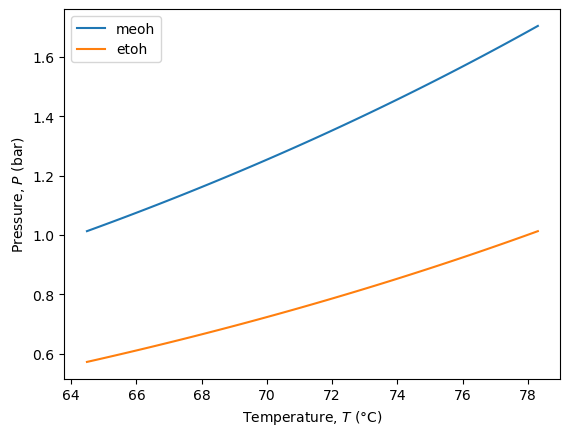

In [2]:
################################################################################
# PURE COMPONENT PROPERTIES
################################################################################
Tmin = opt.root(dP,To,args=(P,antoine['meoh'])).x[0]
Tmax = opt.root(dP,To,args=(P,antoine['etoh'])).x[0]

nPts = 100
T = np.linspace(Tmin,Tmax,nPts)
P1 = np.array([Psat(T[i],antoine['meoh']) for i in range(nPts)])
P2 = np.array([Psat(T[i],antoine['etoh']) for i in range(nPts)])
plt.plot(T-degC_to_K,P1/bar_to_Pa,label='meoh')
plt.plot(T-degC_to_K,P2/bar_to_Pa,label='etoh')
plt.xlabel('Temperature, $T$ (°C)')
plt.ylabel('Pressure, $P$ (bar)')
plt.legend()
plt.show()

In [3]:
################################################################################
# DEFINE CONSTANTS
################################################################################
# feed flow and quality
F = np.array([75,25]) * k_to_u/hr_to_s
q = 1

# purity
DbyF = np.array([0.999,0.01]) # [light key split, heavy key split]

# reflux ratio
RByRmin = 1.2

################################################################################
# MAIN CODE
################################################################################
print('Feed')
print('  F = %.3g kmol/hr' % (sum(F)*hr_to_s/k_to_u))
z = F[0]/sum(F)
print('  z1 = %.3g' % z)
print('  q = %.3g' % q)

print('\nTops')
D = DbyF*F
print('  D = %.3g kmol/hr' % (sum(D)*hr_to_s/k_to_u))
yD = D[0]/sum(D)
print('  y1 = %.3g' % yD)

print('\nBottoms')
B = F-D
print('  B = %.3g kmol/hr' % (sum(B)*hr_to_s/k_to_u))
xB = B[0]/sum(B)
print('  x1 = %.3g' % xB)

print('\nFenske-Underwood-Gilliland')
# Fenske Equation (Table 11.13.7)
alphaD = P1[0]/P2[0]
alphaB = P1[-1]/P2[-1]
alpha = np.sqrt(alphaD*alphaB)
print('  alpha = %.3g' % (alpha))

Nmin = np.log((yD/(1-yD))/(xB/(1-xB)))/np.log(alpha)
print('  Nmin  = %.3g' % Nmin)

# Underwood Equation
print('')
theta = opt.root(underwood,(alpha+1)/2,args=(z,q,alpha)).x
print('  theta = %.3g' % theta)
Rmin = alpha*yD/(alpha-theta) + (1-yD)/(1-theta) - 1
print('  Rmin  = %.3g' % Rmin)

# Gilliland Equation
print('')
R = RByRmin*Rmin
print('  R = %.3g' % R)
X = (R-Rmin)/(R+1)
Y = 0.5
Y = opt.root(gilliland,Y,args=(X)).x
N = (Y + Nmin)/(1 - Y)
print('  N = %.3g' % N)

Feed
  F = 100 kmol/hr
  z1 = 0.75
  q = 1

Tops
  D = 75.2 kmol/hr
  y1 = 0.997

Bottoms
  B = 24.8 kmol/hr
  x1 = 0.00302

Fenske-Underwood-Gilliland
  alpha = 1.73
  Nmin  = 21.1

  theta = 1.12
  Rmin  = 1.8

  R = 2.16
  N = 47


In [4]:
################################################################################
# McCABE-THIELE
################################################################################
nPts = 1001
x = np.linspace(0,1,nPts)

# equilibrium compositions
yi = np.zeros_like(x)
Tx = np.zeros_like(x)
T0 = Tmax
for i in range(nPts):
    Tx[i] = opt.root(idealx,T0,args=(P,x[i],antoine['meoh'],antoine['etoh'])).x
    T0 = Tx[i]
    yi[i] = x[i]*Psat(Tx[i],antoine['meoh'])/P

# feed line
xF = np.zeros(2)+z
yF = np.zeros(2)+z
if q == 1:
    xF[1] = z
    yF[1] = np.interp(xF[0],x,yi)
else:
    mF = q / (q-1)
    bF = z - mF*z
    xF[1],yF[1] = intersect.intersection(x,yi,x,mF*x+bF)
mmin = (yD-yF[1])/(yD-xF[1])
Rmin = mmin / (1-mmin)

print('Rmin = %.3g' % Rmin)
R = RByRmin*Rmin
print('R = %.3g' % R)

# enriching line
mE = R/(R+1) # slope
bE = yD - mE*yD
xE = np.array([yD,xF[1]])
yE = mE*xE+bE

# need the intersection of feed and enriching
xF[1],yF[1] = intersect.intersection(xF,yF,xE,yE)
xE = np.array([yD,xF[1]])
yE = np.array([yD,yF[1]])

print('\nFeed line:')
print('  (%.2f,%.2f) --> (%.2f,%.2f)' % (xF[0],yF[0],xF[1],yF[1]))

print('\nEnriching line:')
print('  (%.2f,%.2f) --> (%.2f,%.2f)' % (xE[0],yE[0],xE[1],yE[1]))

# stripping line
xS = np.array([xB,xF[1]])
yS = np.array([xB,yF[1]])
mS = (yS[1]-yS[0])/(xS[1]-xS[0])
bS = yS[0] - mS*xS[0]

print('\nStripping line:')
print('  (%.2f,%.2f) --> (%.2f,%.2f)' % (xS[0],yS[0],xS[1],yS[1]))


# stages
print('\nStepping off stages:')
xMT = [yD]
yMT = [yD]
N = 0
while xMT[-1] > xB:
    # go to equilibrium line
    yMT.append(yMT[-1])
    xMT.append(np.interp(yMT[-1],yi,x))
    # go to operating line
    xMT.append(xMT[-1])
    if xMT[-1] > xF[-1]:
        # go to enriching line
        yMT.append(np.interp(xMT[-1],x,mE*x+bE))
    else:
        # go to stripping line
        yMT.append(np.interp(xMT[-1],x,mS*x+bS))
    N += 1
    print('  %2d (%.2f,%.2f)' % (N, xMT[-2],yMT[-2]))

Rmin = 1.74
R = 2.09

Feed line:
  (0.75,0.75) --> (0.75,0.83)

Enriching line:
  (1.00,1.00) --> (0.75,0.83)

Stripping line:
  (0.00,0.00) --> (0.75,0.83)

Stepping off stages:
   1 (0.99,1.00)
   2 (0.99,0.99)
   3 (0.99,0.99)
   4 (0.98,0.99)
   5 (0.98,0.99)
   6 (0.97,0.98)
   7 (0.97,0.98)
   8 (0.96,0.98)
   9 (0.95,0.97)
  10 (0.94,0.96)
  11 (0.93,0.96)
  12 (0.92,0.95)
  13 (0.90,0.94)
  14 (0.89,0.93)
  15 (0.87,0.92)
  16 (0.85,0.91)
  17 (0.84,0.90)
  18 (0.82,0.89)
  19 (0.80,0.88)
  20 (0.79,0.87)
  21 (0.77,0.85)
  22 (0.75,0.84)
  23 (0.74,0.83)
  24 (0.72,0.82)
  25 (0.69,0.80)
  26 (0.65,0.77)
  27 (0.60,0.72)
  28 (0.54,0.67)
  29 (0.46,0.59)
  30 (0.37,0.51)
  31 (0.29,0.41)
  32 (0.22,0.32)
  33 (0.16,0.24)
  34 (0.11,0.17)
  35 (0.08,0.12)
  36 (0.05,0.08)
  37 (0.03,0.06)
  38 (0.02,0.04)
  39 (0.01,0.02)
  40 (0.01,0.02)
  41 (0.01,0.01)
  42 (0.00,0.01)
  43 (0.00,0.00)


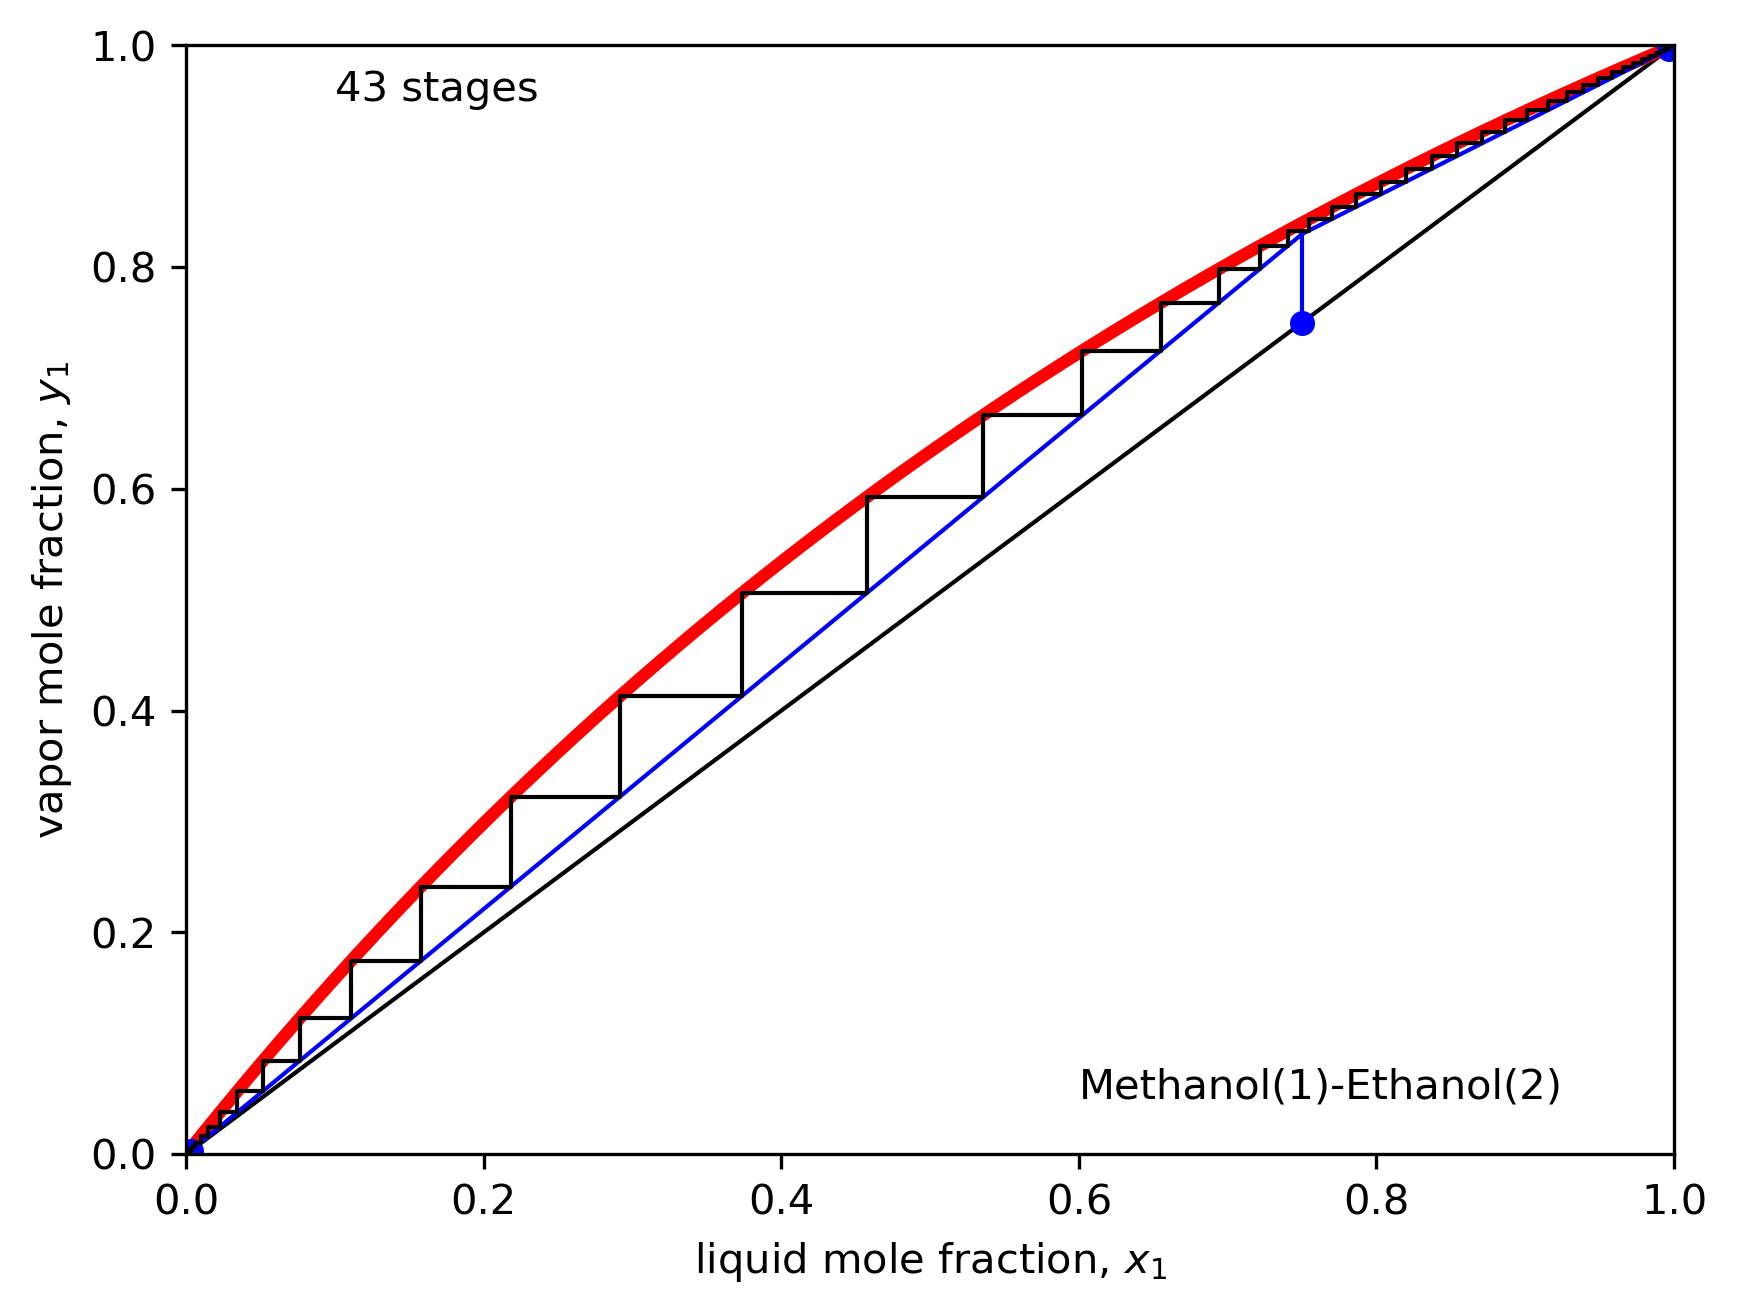

In [5]:
################################################################################
# McCABE-THIELE
################################################################################
nPts = 1001
x = np.linspace(0,1,nPts)

plt.figure(dpi=300)
plt.plot(x,x,'k-',lw=1)
plt.xlabel(r'liquid mole fraction, $x_1$')
plt.xlim(0,1)
plt.ylabel(r'vapor mole fraction, $y_1$')
plt.ylim(0,1)

# equilibrium compositions
plt.plot(x,yi,'r-',lw=3)

# feed line
plt.plot(z,z,'bo',markersize=5)
plt.plot(xF,yF,'b-',lw=1)

# enriching line
plt.plot(yD,yD,'bo',markersize=5)
plt.plot(xE,yE,'b-',lw=1)

# stripping line
plt.plot(xS,yS,'b-',lw=1)
plt.plot(xB,xB,'bo',markersize=5)

# stages
plt.plot(xMT,yMT,'k-',lw=1)
plt.text(0.1,0.95,'%d stages' % N)
plt.text(0.6,0.05,'Methanol(1)-Ethanol(2)')
plt.savefig(outFile + '.png')

In [6]:
print('\n1) Molar Flow Rates:')
L = np.zeros(2)
V = np.zeros(2)
L[0] = R*sum(D)
V[0] = L[0]+sum(D)
print('  V    = %.3g kmol/hr' % (V[0]*hr_to_s/k_to_u))
print('  L    = %.3g kmol/hr' % (L[0]*hr_to_s/k_to_u))
L[1] = q*sum(F) + L[0]
V[1] = V[0] - sum(F)*(1-q)
print('  Vbar = %.3g kmol/hr' % (V[1]*hr_to_s/k_to_u))
print('  Lbar = %.3g kmol/hr' % (L[1]*hr_to_s/k_to_u))
print('  Vbar/B = %.3g' % (V[1]/sum(B)))

print('\n2) Densities:')
T = np.array([Tmin,Tmax])
rho_V = P*mw/Rg/T
print('  rho_V    = %.3g kg/m^3' % rho_V[0])
print('  rho_Vbar = %.3g kg/m^3' % rho_V[1])
rho_L = np.array([772,789])
print('  rho_L    = %.3g kg/m^3' % rho_L[0])
print('  rho_Lbar = %.3g kg/m^3' % rho_L[1])

print('\n3) Liquid/Vapor:')
Flv = L/V*np.sqrt(rho_V/rho_L)
print('  F_LV    = %.3g' % Flv[0])
print('  F_LVbar = %.3g' % Flv[1])


1) Molar Flow Rates:
  V    = 232 kmol/hr
  L    = 157 kmol/hr
  Vbar = 232 kmol/hr
  Lbar = 257 kmol/hr
  Vbar/B = 9.36

2) Densities:
  rho_V    = 1.16 kg/m^3
  rho_Vbar = 1.6 kg/m^3
  rho_L    = 772 kg/m^3
  rho_Lbar = 789 kg/m^3

3) Liquid/Vapor:
  F_LV    = 0.0262
  F_LVbar = 0.0498


In [7]:
print('\n4) Flooding Parameters')
a,b,c = (0.94506,0.70234,0.22618)
Flv_i = np.logspace(-2,0.3)
Csb_i = 10**(-a-b*np.log10(Flv_i)-c*np.log10(Flv_i)**2)
Csb_max = np.max(Csb_i)
Flv_max = Flv_i[np.argmax(Csb_i)]
Csb = np.zeros(2)
for i,Flv_i in enumerate(Flv):
    if Flv_i < Flv_max:
        Csb[i] = Csb_max
    else:
        Csb[i] = 10**(-a-b*np.log10(Flv_i)-c*np.log10(Flv_i)**2)
print('  C_sb    = %.3g' % Csb[0])
print('  C_sbbar = %.3g' % Csb[1])

print('\n5) Flooding Velocity')
sigma = np.array([22.5,22.4]) # dynes/cm^2, surface tension
uf = Csb * (sigma/20)**0.2*np.sqrt((rho_L-rho_V)/rho_V)*ft_to_m
print('  u_f    = %.3g m/s' % uf[0])
print('  u_fbar = %.3g m/s' % uf[1])

print('\n6) Design Velocity')
uByuf = 0.75
u = uf*uByuf
print('  u    = %.3g m/s' % u[0])
print('  ubar = %.3g m/s' % u[1])


print('\n7) Active Area')
A = V*mw/rho_V/u
print('  A    = %.3g m^2' % A[0])
print('  Abar = %.3g m^2' % A[1])


print('\n8) Design Area')
AbyAT = 0.88
AT = A/AbyAT
print('  A_T    = %.3g m^2' % AT[0])
print('  A_Tbar = %.3g m^2' % AT[1])

print('\n9) Tower Diameter')
DT = np.sqrt(4/np.pi*AT)
print('  D_T    = %.3g m' % DT[0])
print('  D_Tbar = %.3g m' % DT[1])

print('\nCheck Flooding Fraction at Larger Diameter')
uc = V*mw/rho_V/A[0]
print('  At top diameter:')
print('    u/uf = %.2f' % (uc[0]/uf[0]))
print('    u/uf = %.2f' % (uc[1]/uf[1]))

uc = V*mw/rho_V/A[1]
print('  At bottom diameter:')
print('    u/uf = %.2f' % (uc[0]/uf[0]))
print('    u/uf = %.2f' % (uc[1]/uf[1]))


4) Flooding Parameters
  C_sb    = 0.398
  C_sbbar = 0.386

5) Flooding Velocity
  u_f    = 3.21 m/s
  u_fbar = 2.67 m/s

6) Design Velocity
  u    = 2.41 m/s
  ubar = 2 m/s

7) Active Area
  A    = 0.743 m^2
  Abar = 0.93 m^2

8) Design Area
  A_T    = 0.844 m^2
  A_Tbar = 1.06 m^2

9) Tower Diameter
  D_T    = 1.04 m
  D_Tbar = 1.16 m

Check Flooding Fraction at Larger Diameter
  At top diameter:
    u/uf = 0.75
    u/uf = 0.94
  At bottom diameter:
    u/uf = 0.60
    u/uf = 0.75
